In [ ]:
import tensorflow as tf
import sys
from keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as pyplot
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.layers import BatchNormalization
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K

In [ ]:
## PARAMETERS
LEARNING_RATE = 0.001
BATCH_SIZE = 64
MOMENTUM = 0.9 # convergence optimization
EPOCH = 70
VERBOSE = 1 # display style
OUTPUT_CLASS = 10
INPUT_SHAPE = (32,32,3)

(X_train, y_train), (X_test,y_test) = datasets.cifar10.load_data()
LABELS = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [ ]:
X_unlabeled = X_train[35000:50000]
X_train,y_train = (X_train[:35000], y_train[:35000])
X_train.shape , y_train.shape

((35000, 32, 32, 3), (35000, 1))

In [ ]:
y_train, y_test = data_preparation(y_train, y_test)

In [ ]:
X_train, X_test,X_unlabeled = image_resizing(X_train,X_test,X_unlabeled)

In [ ]:
cnn_model = create_model(INPUT_SHAPE,LEARNING_RATE,MOMENTUM,OUTPUT_CLASS)

In [ ]:
cnn_model.summary()

Pretrain the model for the maximum accuracy using all the available labeled data.

In [ ]:
history = cnn_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH,validation_data=(X_test, y_test),verbose=VERBOSE)
_, acc = cnn_model.evaluate(X_test, y_test)

Save the model and history

In [ ]:
import pickle
cnn_model.save('cnn_model_70Epoch')

with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

To use the existing history file and the trained model;

In [ ]:
from keras.callbacks import History
import pickle

with open('history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

history = History()
history.history = loaded_history

cnn_model = tf.keras.models.load_model('content/cnn_model_70Epoch')

In [ ]:
print('> %.3f' % (acc * 100.0))
plot_it(history)

313/313 [==============================] - 3s 4ms/step


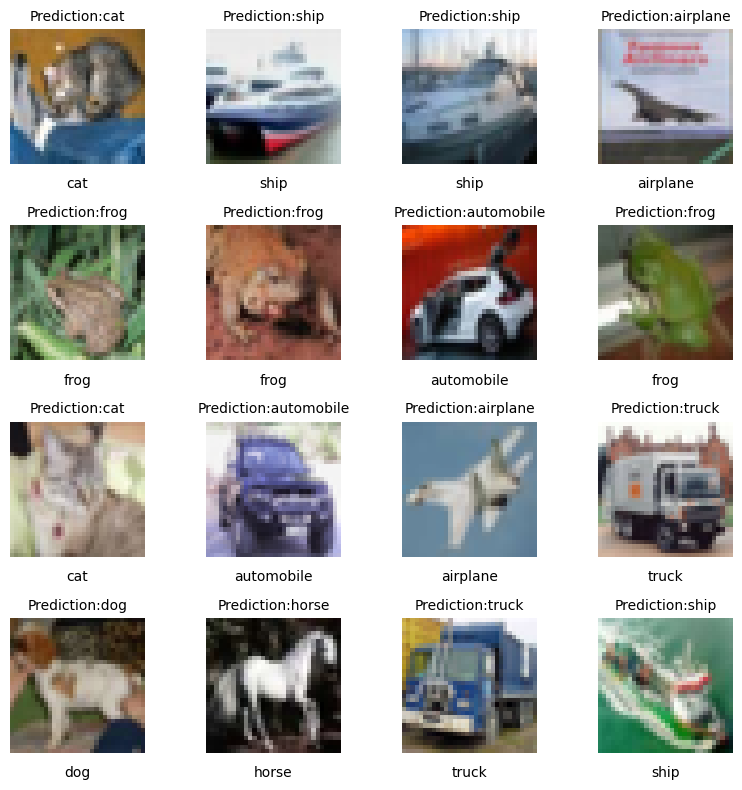

In [ ]:
y_predictions_raw = cnn_model.predict(X_test)
y_predictions_logits = [np.argmax(data) for data in y_predictions_raw] # raw to index
y_true_logits = [np.argmax(data) for data in y_test] # categorial to index

fig, axes = pyplot.subplots(nrows=4, ncols=4, figsize=(8, 8))
# Iterate through the chosen number of images
for i in range(16):
    # Get the image and its corresponding label
    image = X_test[i]
    color = ''
    if(LABELS[y_predictions_logits[i]] == LABELS[y_true_logits[i]]):
        color = 'black'
    else:
        color = 'red'

    # Plot the image on the corresponding subplot
    ax = axes[i // 4, i % 4]
    ax.imshow(image)
    ax.set_title(f'Prediction:{LABELS[y_predictions_logits[i]]}',fontsize=10,color=color)
    ax.text(0.5, -0.15, f'{LABELS[y_true_logits[i]]}', va='center',ha='center', transform=ax.transAxes)
    ax.axis('off')  # Turn off axis labels for clarity
pyplot.tight_layout()
pyplot.show()


Involving Unlabeled Data using Pseudo-Labeling Technique

In [ ]:
THRESHOLD = 0.8
NUMBER_OF_ITERATIONS = 70
EPOCH_PER_ITERATION = 5

for i in range(NUMBER_OF_ITERATIONS):
  predictions_unlabeled = cnn_model.predict(X_unlabeled)
  confidence_mask = np.max(predictions_unlabeled, axis=1) > THRESHOLD
  
  pseudo_labeled_data = X_unlabeled[confidence_mask]

  pseudo_labels = np.argmax(predictions_unlabeled[confidence_mask], axis=1)
  pseudo_labels = to_categorical(pseudo_labels.reshape(-1, 1))

  combined_data = np.concatenate((X_train, X_unlabeled[confidence_mask]))
  combined_labels = np.concatenate((y_train, pseudo_labels))

  cnn_model.fit(combined_data, combined_labels, batch_size=BATCH_SIZE, epochs=1,validation_data=(X_test, y_test),verbose=VERBOSE)

In [ ]:
cnn_model.save('cnn_model_semisupervised')

Functions

In [ ]:
def data_preparation(y_train,y_test):
  # one-hot encoding for labels.
  # string label_to --> zeros,ones
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  return y_train,y_test

In [ ]:
def image_resizing(X_train,X_test,X_unlabeled):

  ## integer to floats
  norm_X_train = X_train.astype('float32')
  norm_X_test = X_test.astype('float32')
  norm_X_unlabeled = X_unlabeled.astype('float32')

  # normalize to range 0-1
  norm_X_train = norm_X_train / 255.0
  norm_X_test = norm_X_test / 255.0
  norm_X_unlabeled = norm_X_unlabeled / 255.0
  return norm_X_train, norm_X_test, norm_X_unlabeled

In [ ]:
def create_model(input_shape, learning_rate, momentum, output_class):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(output_class, activation='softmax'))

    # compile model
    opt = SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def plot_it(history):

    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    pyplot.legend()
    pyplot.show()

    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    pyplot.legend()
    pyplot.show()
